# Library

In [1]:
import math
import matplotlib.pyplot as plt
import simpy
import json
import random
import utils
import sys

import utils
from Satellite import *
from UE import *
from config import *

# Handover Estimation

In [2]:
# M = 2 * R * R * math.acos(d / 2 / R) - d * (R*R - d*d/4)**0.5
# S = math.pi * R * R - M
# S * N / pi / R / R

# The number of devices requiring handover
def handout(R,N,d):
    pi = math.pi
    RES = N - 2*N/pi * math.acos(d / 2 / R) + d*N/pi * (1/R/R - (d*d)/(4*R**4))**0.5
    return RES

In [3]:
# Example
R = 25 * 1000 # 25 km
v = 7.56 * 1000 # 7.56 km / h
t = 1 # 1 second
d = v * t # distance
N = 65519
number_handover = handout(R,N,d)
print(number_handover)

12565.087000358559


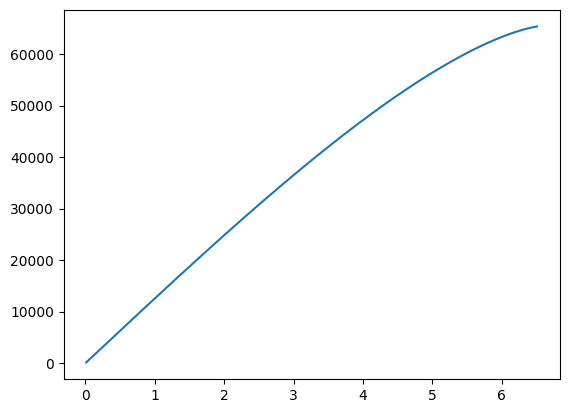

In [4]:
t_upperbound = 2*R/v - 0.1

x = []
timestamp = 0.01
while timestamp < t_upperbound:
    x.append(timestamp)
    timestamp += 0.01
y = []
for t in x:
    y.append(handout(R, N, v*t))
plt.plot(x, y, linestyle='-')

# Utils

# Experiment Setup

The time step is 1 ms

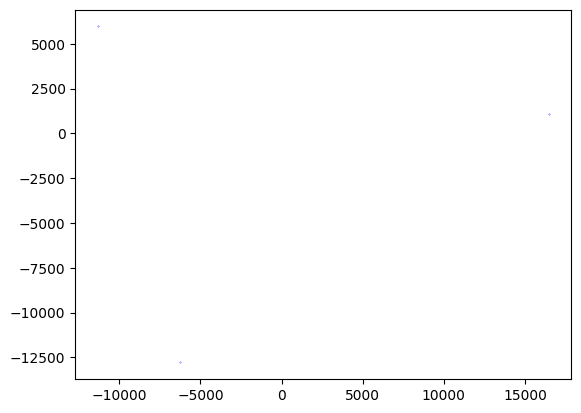

In [5]:
# uniform devices generator
def generate_points(n, R, x, y):
    def generate_one(R,x,y):
        r = R * math.sqrt(random.uniform(0, 1))
        theta = random.uniform(0, 1) * 2 * math.pi
        px = x + r * math.cos(theta)
        py = y + r * math.sin(theta)
        return (px, py)
    points = []
    for i in range(n):
        points.append(generate_one(R,x,y))
    return points

SATELLITE_R = 25 * 1000
NUMBER_UE = 3
SATELLITE_V = 7.56 * 1000
POSITIONS = generate_points(NUMBER_UE, SATELLITE_R-1*1000, 0, 0)
x_coords, y_coords = zip(*POSITIONS)
plt.scatter(x_coords, y_coords, color='blue', s = 0.05)
plt.show()

# Design Idea

## Communication Channel

1. The sender should wait the time and put the message in the receiver's Q
2. The sending action should through method "send_message()"

## Signal Processing

1. The processing of the signal is using CPU tasks

## Identity management

1. Each device including satellite will have a unique identifier (Not implemented)

## Message format

1. The message should follow the same format (Not implemented)

# Handover Protocol

## UE Class

In [6]:
import math
import simpy

from Base import *
from config import *


class UE(Base):
    def __init__(self,
                 identity,
                 position_x,
                 position_y,
                 satellite_ground_delay,
                 serving_satellite,
                 env):

        # Config Initialization
        Base.__init__(self,
                      identity=identity,
                      position_x=position_x,
                      position_y=position_y,
                      env=env,
                      satellite_ground_delay=satellite_ground_delay,
                      object_type="UE")

        self.serving_satellite = serving_satellite

        # Logic Initialization
        self.messageQ = simpy.Store(env)
        self.cpus = simpy.Resource(env, UE_CPU)
        self.state = ACTIVE
        self.satellites = None

        self.active = True
        self.hasHandoverConfiguration = False
        self.sentHandoverRequest = False
        self.sentRrcReconfigurationComplete = False
        self.handoverComplete = False

        self.lock = False  # I only want this to perform one handover
        self.targetID = None

        # Running Process
        env.process(self.init())
        env.process(self.handle_messages())

        env.process(self.action_monitor())

    # =================== UE functions ======================
    def handle_messages(self):
        while True:
            msg = yield self.messageQ.get()
            print(f"{self.type} {self.identity} start handling msg:{msg} at time {self.env.now}")
            data = json.loads(msg)
            self.env.process(self.cpu_processing(data))

    def cpu_processing(self, msg):
        with self.cpus.request() as request:
            task = msg['task']
            if task == RRC_RECONFIGURATION:
                yield request
                satid = msg['from']
                if satid == self.serving_satellite.identity and self.state == WAITING_RRC_CONFIGURATION:
                    # get candidate target
                    targets = msg['targets']
                    # choose target
                    self.targetID = targets[0]
                    self.hasHandoverConfiguration = True
                    print(f"{self.type} {self.identity} receives the configuration at {self.env.now}")
            elif task == RRC_RECONFIGURATION_COMPLETE_RESPONSE:
                yield request
                satid = msg['from']
                satellite = self.satellites[satid]
                if self.covered_by(satid):
                    self.serving_satellite = satellite
                    self.handoverComplete = True
                    print(f"{self.type} {self.identity} finished handover at {self.env.now}")

    def action_monitor(self):
        while True:
            # send measurement report
            if self.send_request_condition() and self.state == ACTIVE and not self.lock:
                data = {
                    "task": MEASUREMENT_REPORT,
                }
                self.env.process(
                    self.send_message(
                        delay=self.satellite_ground_delay,
                        msg=data,
                        Q=self.serving_satellite.messageQ,
                        to=self.serving_satellite
                    )
                )
                self.state = WAITING_RRC_CONFIGURATION
                self.lock = True
            if self.hasHandoverConfiguration:  # When the UE has the configuration
                if self.targetID and self.covered_by(self.targetID) and not self.sentRrcReconfigurationComplete:
                    target = self.satellites[self.targetID]
                    data = {
                        "task": RRC_RECONFIGURATION_COMPLETE,
                    }
                    self.env.process(
                        self.send_message(
                            delay=self.satellite_ground_delay,
                            msg=data,
                            Q=target.messageQ,
                            to=target
                        )
                    )
                    self.sentRrcReconfigurationComplete = True
            # switch to inactive
            if self.outside_coverage() and self.state != INACTIVE:
                print(
                    f"UE {self.identity} lost connection at time {self.env.now} from satellite {self.serving_satellite.identity}")
                self.state = INACTIVE
            yield self.env.timeout(1)

    # ==================== Utils (Not related to Simpy) ==============
    def covered_by(self, satelliteID):
        satellite = self.satellites[satelliteID]
        d = math.sqrt(((self.position_x - satellite.position_x) ** 2) + (
                (self.position_y - satellite.position_y) ** 2))
        return d <= 25 * 1000

    def send_request_condition(self):
        d = math.sqrt(((self.position_x - self.serving_satellite.position_x) ** 2) + (
                (self.position_y - self.serving_satellite.position_y) ** 2))
        decision = (d > 23 * 1000 and self.position_x < self.serving_satellite.position_x
                    and self.state == ACTIVE)
        return decision

    def outside_coverage(self):
        d = math.sqrt(((self.position_x - self.serving_satellite.position_x) ** 2) + (
                (self.position_y - self.serving_satellite.position_y) ** 2))
        # TODO this is not accurate
        return d >= 25 * 1000 and self.position_x < self.serving_satellite.position_x


## Satellite Class

In [7]:
import simpy

from Base import *
from config import *


class Satellite(Base):
    def __init__(self,
                 identity,
                 position_x,
                 position_y,
                 velocity,
                 satellite_ground_delay,
                 ISL_delay,
                 env):

        Base.__init__(self,
                      identity=identity,
                      position_x=position_x,
                      position_y=position_y,
                      env=env,
                      satellite_ground_delay=satellite_ground_delay,
                      object_type="satellite")

        # Config Initialization
        self.ISL_delay = ISL_delay
        self.velocity = velocity

        # Logic Initialization
        self.messageQ = simpy.Store(env)
        self.UEs = None
        self.satellites = None
        self.cpus = simpy.Resource(env, SATELLITE_CPU)  # Concurrent processing

        # Running process
        self.env.process(self.init())  # Print Deployment information
        self.env.process(self.update_position())
        self.env.process(self.handle_messages())

    def handle_messages(self):
        """ Get the task from message Q and start a CPU processing process """
        while True:
            msg = yield self.messageQ.get()
            print(f"{self.type} {self.identity} start handling msg:{msg} at time {self.env.now}")
            data = json.loads(msg)
            self.env.process(self.cpu_processing(data))

    # =================== Satellite functions ======================

    def cpu_processing(self, msg):
        """ Processing the task from the message Q

        Args:
            msg: the json object from message Q

        """
        with self.cpus.request() as request:
            # Get the task and processing time
            task = msg['task']
            processing_time = PROCESSING_TIME[task]

            # handle the task by cases
            if task == MEASUREMENT_REPORT:
                ueid = msg['from']
                UE = self.UEs[ueid]
                if self.connected(UE):
                    yield request
                    yield self.env.timeout(processing_time)
                if self.connected(UE):
                    # send the response to UE
                    data = {
                        "task": HANDOVER_REQUEST,
                        "ueid": ueid
                    }
                    # for now, just send it to the satellite 2. TODO
                    target_satellite = self.satellites[2]
                    self.env.process(
                        self.send_message(
                            delay=self.ISL_delay,
                            msg=data,
                            Q=target_satellite.messageQ,
                            to=target_satellite
                        )
                    )
            elif task == HANDOVER_ACKNOWLEDGE:
                satellite_id = msg['from']
                ueid = msg['ueid']
                UE = self.UEs[ueid]
                if self.connected(UE):
                    yield request
                    yield self.env.timeout(processing_time)
                if self.connected(UE):
                    data = {
                        "task": RRC_RECONFIGURATION,
                        "targets": [satellite_id],
                    }
                    self.env.process(
                        self.send_message(
                            delay=self.satellite_ground_delay,
                            msg=data,
                            Q=UE.messageQ,
                            to=UE
                        )
                    )
            elif task == HANDOVER_REQUEST:
                satellite_id = msg['from']
                ueid = msg['ueid']
                yield request
                yield self.env.timeout(processing_time)
                data = {
                    "task": HANDOVER_ACKNOWLEDGE,
                    "ueid": ueid
                }
                source_satellite = self.satellites[satellite_id]
                self.env.process(
                    self.send_message(
                        delay=self.ISL_delay,
                        msg=data,
                        Q=source_satellite.messageQ,
                        to=source_satellite
                    )
                )
            elif task == RRC_RECONFIGURATION_COMPLETE:
                ue_id = msg['from']
                UE = self.UEs[ue_id]
                yield request
                yield self.env.timeout(processing_time)
                data = {
                    "task": RRC_RECONFIGURATION_COMPLETE_RESPONSE,
                }
                self.env.process(
                    self.send_message(
                        delay=self.satellite_ground_delay,
                        msg=data,
                        Q=UE.messageQ,
                        to=UE
                    )
                )

    def update_position(self):
        """ Continuous updating the object location. """
        while True:
            yield self.env.timeout(1)  # Time between position updates
            # Update x and y based on velocity
            # Calculate time ratio
            ratio = 1 / 1000
            # direction set to right
            self.position_x += self.velocity * ratio

    # ==================== Utils (Not related to Simpy) ==============
    def connected(self, UE):
        return UE.state != INACTIVE and UE.serving_satellite.identity == self.identity


# Running Experiment

In [8]:
POSITIONS = [(-25000+100, 0),(-13000, -20711), (-13000,20711)]
#POSITIONS = [(-13000, -20711)]


env = simpy.Environment()
# Deploy source Satellite

satellite_source = Satellite(
    identity=1,
    position_x=0,
    position_y=0,
    velocity=SATELLITE_V,
    satellite_ground_delay=SATELLITE_GROUND_DELAY,
    ISL_delay=SATELLITE_SATELLITE_DELAY,
    env=env)

UEs = {}
satellites = {}
satellites[1] = satellite_source
# Deploying UEs following randomly generated positions
for index, position in enumerate(POSITIONS, start=1):
    UEs[index] = UE(
        identity=index,
        position_x=position[0],
        position_y=position[1],
        serving_satellite=satellite_source,
        satellite_ground_delay=SATELLITE_GROUND_DELAY,
        env=env)
    
# Deploying other satellites
for i in range(2, NUMBER_SATELLITES+1):
    satellites[i] = Satellite(
        identity=i,
        position_x= -15 * 1000,
        position_y=0,
        velocity=SATELLITE_V,
        satellite_ground_delay=SATELLITE_GROUND_DELAY,
        ISL_delay=SATELLITE_SATELLITE_DELAY,
        env=env
    )

for identity in satellites:
    satellites[identity].UEs = UEs
    satellites[identity].satellites = satellites

for identity in UEs:
    UEs[identity].satellites = satellites
    

env.run(until=5000)

satellite 1 deployed at time 0, positioned at (0,0)
UE 1 deployed at time 0, positioned at (-24900,0)
UE 2 deployed at time 0, positioned at (-13000,-20711)
UE 3 deployed at time 0, positioned at (-13000,20711)
satellite 2 deployed at time 0, positioned at (-15000,0)
UE 1 sends satellite 1 the message {"task": "MEASUREMENT_REPORT", "from": 1, "to": 1} at 0
UE 2 sends satellite 1 the message {"task": "MEASUREMENT_REPORT", "from": 2, "to": 1} at 0
UE 3 sends satellite 1 the message {"task": "MEASUREMENT_REPORT", "from": 3, "to": 1} at 0
UE 1 lost connection at time 14 from satellite 1
satellite 1 start handling msg:{"task": "MEASUREMENT_REPORT", "from": 1, "to": 1} at time 30
satellite 1 start handling msg:{"task": "MEASUREMENT_REPORT", "from": 2, "to": 1} at time 30
satellite 1 start handling msg:{"task": "MEASUREMENT_REPORT", "from": 3, "to": 1} at time 30
satellite 1 sends satellite 2 the message {"task": "HANDOVER_REQUEST", "ueid": 2, "from": 1, "to": 2} at 30.5
satellite 1 sends sat

# Result Analysis

In [9]:
counter_request = 0
counter_success = 0
Success_UE_Positions = []
for i in UEs:
    ue = UEs[i]
    if ue.sentHandoverRequest == True:
        counter_request += 1
    if ue.hasHandoverConfiguration == True:
        counter_success += 1
        Success_UE_Positions.append((ue.position_x, ue.position_y))
print(f"{counter_request} UEs sent the handover requests")
print(f"{counter_success} UEs received the handover configuration")

0 UEs sent the handover requests
2 UEs received the handover configuration


In [10]:
satellite 1 deployed at time 0, positioned at (0,0)
UE 1 deployed at time 0, positioned at (-24900,0)
UE 2 deployed at time 0, positioned at (-13000,-20711)
UE 3 deployed at time 0, positioned at (-13000,20711)
satellite 2 deployed at time 0, positioned at (-15000,0)
UE 1 sends satellite 1 the message {"task": "MEASUREMENT_REPORT", "from": 1, "to": 1} at 0
UE 2 sends satellite 1 the message {"task": "MEASUREMENT_REPORT", "from": 2, "to": 1} at 0
UE 3 sends satellite 1 the message {"task": "MEASUREMENT_REPORT", "from": 3, "to": 1} at 0
UE 1 lost connection at time 14 from satellite 1
satellite 1 start handling msg:{"task": "MEASUREMENT_REPORT", "from": 1, "to": 1} at time 30
satellite 1 start handling msg:{"task": "MEASUREMENT_REPORT", "from": 2, "to": 1} at time 30
satellite 1 start handling msg:{"task": "MEASUREMENT_REPORT", "from": 3, "to": 1} at time 30
satellite 1 sends satellite 2 the message {"task": "HANDOVER_REQUEST", "ueid": 2, "from": 1, "to": 2} at 30.5
satellite 1 sends satellite 2 the message {"task": "HANDOVER_REQUEST", "ueid": 3, "from": 1, "to": 2} at 31.0
satellite 2 start handling msg:{"task": "HANDOVER_REQUEST", "ueid": 2, "from": 1, "to": 2} at time 40.5
satellite 2 sends satellite 1 the message {"task": "HANDOVER_ACKNOWLEDGE", "ueid": 2, "from": 2, "to": 1} at 41.0
satellite 2 start handling msg:{"task": "HANDOVER_REQUEST", "ueid": 3, "from": 1, "to": 2} at time 41.0
satellite 2 sends satellite 1 the message {"task": "HANDOVER_ACKNOWLEDGE", "ueid": 3, "from": 2, "to": 1} at 41.5
satellite 1 start handling msg:{"task": "HANDOVER_ACKNOWLEDGE", "ueid": 2, "from": 2, "to": 1} at time 51.0
satellite 1 sends UE 2 the message {"task": "RRC_RECONFIGURATION", "targets": [2], "from": 1, "to": 2} at 51.1
satellite 1 start handling msg:{"task": "HANDOVER_ACKNOWLEDGE", "ueid": 3, "from": 2, "to": 1} at time 51.5
satellite 1 sends UE 3 the message {"task": "RRC_RECONFIGURATION", "targets": [2], "from": 1, "to": 3} at 51.6
UE 2 start handling msg:{"task": "RRC_RECONFIGURATION", "targets": [2], "from": 1, "to": 2} at time 81.1
UE 2 receives the configuration at 81.1
UE 3 start handling msg:{"task": "RRC_RECONFIGURATION", "targets": [2], "from": 1, "to": 3} at time 81.6
UE 3 receives the configuration at 81.6
UE 2 sends satellite 2 the message {"task": "RRC_RECONFIGURATION_COMPLETE", "from": 2, "to": 2} at 82
UE 3 sends satellite 2 the message {"task": "RRC_RECONFIGURATION_COMPLETE", "from": 3, "to": 2} at 82
satellite 2 start handling msg:{"task": "RRC_RECONFIGURATION_COMPLETE", "from": 2, "to": 2} at time 112
satellite 2 start handling msg:{"task": "RRC_RECONFIGURATION_COMPLETE", "from": 3, "to": 2} at time 112
satellite 2 sends UE 2 the message {"task": "RRC_RECONFIGURATION_COMPLETE_RESPONSE", "from": 2, "to": 2} at 112.1
satellite 2 sends UE 3 the message {"task": "RRC_RECONFIGURATION_COMPLETE_RESPONSE", "from": 2, "to": 3} at 112.19999999999999
UE 2 lost connection at time 133 from satellite 1
UE 3 lost connection at time 133 from satellite 1
UE 2 start handling msg:{"task": "RRC_RECONFIGURATION_COMPLETE_RESPONSE", "from": 2, "to": 2} at time 142.1
UE 2 finished handover at 142.1
UE 3 start handling msg:{"task": "RRC_RECONFIGURATION_COMPLETE_RESPONSE", "from": 2, "to": 3} at time 142.2
UE 3 finished handover at 142.2

SyntaxError: invalid syntax (960462828.py, line 1)